In [29]:
import joblib
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
from collections import defaultdict
from glob import glob
from scipy.stats import iqr
from numpy import median
import json


def make_result_table(datasets, exp_name_templates, output_path):
    def collect_exp_scores(exp_name_template, datasets):
        print("=" * 80)
        all_files = glob(os.path.join(output_path, exp_name_template, "dev_scores.json"))
        
        print(f"Find {len(all_files)} experiments fit into {exp_name_template}")

        def read_last_eval(fname):
            with open(fname) as f:
                e = json.loads(f.readlines()[-1])
            return e["accuracy"]

        acc_by_dataset = defaultdict(lambda: list())

        def parse_expname(fname):
            # Easiest way for now is to assume fixed structure
            elements = fname.split("/")[-2].split("_")
            
            model = elements[0]
            dataset = "_".join(elements[1:4])
            seed  = elements[5]
            spec = elements[-3:]
            
            return model, dataset, seed, spec

        for fname in all_files:
            result = read_last_eval(fname)
            model, dataset, seed, spec = parse_expname(fname)
            acc_by_dataset[dataset].append(result)

        def result_str(acc_list):
            if len(acc_list) > 1:
                return f"{median(acc_list) * 100:.2f} ({iqr(acc_list) * 100:.2f})"
            else:
                return f"{acc_list[0] * 100:.2f}"

        outputs = []
        for dataset in datasets:
            acc_list = acc_by_dataset[dataset]
            outputs.append(result_str(acc_list))

        print(", ".join([f"{dataset}: {value}" for dataset, value in zip(datasets, outputs)]))
        return ",".join(outputs)

    csv_lines = ["template," + (",".join(datasets))]
    for exp_name_template in exp_name_templates:
        csv_lines.append(f"{exp_name_template}," + collect_exp_scores(exp_name_template, datasets))

    output_fname = os.path.join(output_path, "summary.csv")
    with open(output_fname, "w") as f:
        for line in csv_lines:
            f.write(line + "\n")
    print(f"Save result to {output_fname}")

In [31]:
datasets = "realsumm_2class_split42,realsumm_2class_split4649,realsumm_2class_split91238"#,WMT_de_en_2class,WMT_zh_en_2class"
datasets = datasets.split(",")
exp_name_templates = "t03b_realsumm*"
exp_name_templates = exp_name_templates.split()

make_result_table(datasets, exp_name_templates, "t-few-master/exp_out")

Find 36 experiments fit into t03b_realsumm*
realsumm_2class_split42: 55.52 (6.04), realsumm_2class_split4649: 55.73 (5.10), realsumm_2class_split91238: 49.38 (10.73)
Save result to t-few-master/exp_out/summary.csv


## Visualization 

1. Step 1. For all T0 related datasets: `t03b_realsumm_2class_split_*` compute correlation w/ human judgements.
    - This involves merging w/ original realsumm data. 
    - We can use the `dev_preds.txt` and also the `test.csv` we created for this.
    
    

In [60]:
def compute_metrics(df, human_col, corr_cols=None):
    from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
    from scipy.stats import pearsonr, spearmanr, kendalltau
    
    metrics = {}
    
    kwargs = {"y_true": df['label'], "y_pred": df["pred"], "labels": ["No", "Yes"], "pos_label": "Yes"}
    metrics["precision"] = precision_score(**kwargs)
    metrics["recall"] = recall_score(**kwargs)
    
    kwargs.pop("pos_label")
    tn, fp, fn, tp = confusion_matrix(**kwargs).ravel()
    
    metrics["tn"] = tn
    metrics["fp"] = fp
    metrics["fn"] = fn
    metrics["tp"] = tp
    metrics["n"] = len(df)
    
    kwargs.pop("labels")
    metrics["accuracy"] = accuracy_score(**kwargs)
    
    if "log.label_score" in df.columns and "log.pred_score" in df.columns:
        # scores = np.where(
        #     df['label']=="Yes", 
        #     # if true
        #     df["log.label_score"], 
        #     # else
        #     df["log.pred_score"]
        # )
        scores = np.where(
            (df['label']==df['pred']) & (df["label"] == "yes"), 
            # if true
            df["log.label_score"], 
            # else
            np.where(df["label"] == "Yes" , df["log.label_score"], df["log.pred_score"]))
    
        # TODO - Update scores: should belong to same class
        # scores = np.exp(-scores) # TODO - PERHAPS NORMALIZING THE TWO
        
        metrics[f"pearson_ia3"] = pearsonr(scores, df[human_col])[0]
        metrics[f"spearman_ia3"] = spearmanr(scores, df[human_col])[0]
        metrics[f"kendaltau_ia3"] = kendalltau(scores, df[human_col])[0]
        
        for col in corr_cols:
            metrics[f"pearson_{col}"] = pearsonr(df[col], df[human_col])[0]
            metrics[f"spearman_{col}"] = spearmanr(df[col], df[human_col])[0]
            metrics[f"kendaltau_{col}"] = kendalltau(df[col], df[human_col])[0]
    
    return metrics
        

def get_num_shot(filepath):
    for i in (256, 128, 64, 32, 16, 8, 4, 1):
        if f"shots{i}_" in filepath:
            return i
    raise ValueError(filepath)
    
def get_split_seed(filepath):
    for i in (42, 4649, 91238):
        if f"split{i}_" in filepath:
            return i
    raise ValueError(filepath)
    
    
def get_k_seed(filepath):
    for i in (42, 0, 1024):
        if f"seed{i}_" in filepath:
            return i
    else:
        raise ValueError(filepath)

In [61]:
real_summ_final_results = joblib.load("./experiments/summ_data/real_summ_final_p.pkl")
metrics = ["bart_score_hypo_ref", "bart_score_cnn_hypo_ref", "bart_score_para_hypo_ref", "rouge1_f", "rouge2_f", "rougel_f", "prism_hypo_ref", "mover_score"]

test_files = {i: f"./experiments/summ_data/split_{i}/REALSumm_2class_test.csv" for i in (42, 4649, 91238)}
test_files = {i: pd.read_csv(f) for i, f in test_files.items()}

test_files_results = {}
for k, test_file in test_files.items():
    results = []
    for ix, row in test_file.iterrows():
        doc_data = real_summ_final_results[row["id"]]

        if row["ref_summ"] != doc_data["ref_summ"]:
            raise ValueError()
        elif row["src"] != doc_data["src"]:
            raise ValueError()

        sys_summs = doc_data["sys_summs"]
        for sys_name, sys_data in sys_summs.items():
            if row["sys_name"] == sys_name:
                for metric in metrics:
                    row[metric] = sys_data["scores"][metric]
                results.append(row)
                continue
    test_files_results[k] = pd.DataFrame(results)
test_files_results[42]

,index,id,src,ref_summ,sys_name,sys_summ,sys_score_litepyramid_recall,bin,label,bart_score_hypo_ref,bart_score_cnn_hypo_ref,bart_score_para_hypo_ref,rouge1_f,rouge2_f,rougel_f,prism_hypo_ref,mover_score
0,0,89,Tottenham will subsidise emmanuel adebayor 's ...,Emmanuel Adebayor 's current Tottenham contrac...,two_stage_rl_out.txt,Tottenham will subsidise emmanuel adebayor ' s...,0.333333,"(-0.001, 0.5]",0,-4.579894,-2.178470,-3.097801,0.47368,0.29729,0.44737,-3.459260,0.237375
1,1,36,Islamic state militants have released photogra...,WARNING : GRAPHIC CONTENT . Series of photos a...,bart_out.txt,Gruesome photographs show man being led out of...,0.714286,"(0.5, 1.0]",1,-3.423242,-2.037138,-2.943593,0.45455,0.21538,0.40909,-3.001153,0.257382
2,2,75,Abby bishop 's ( right ) life completely chang...,Abby Bishop took in her two - day - old niece ...,bottom_up_out.txt,Abby bishop was 24 when she took in her two-da...,0.583333,"(0.5, 1.0]",1,-5.456691,-2.202699,-2.779243,0.69307,0.52525,0.69307,-2.688083,0.419994
3,3,86,A cafe owner has laid down a challenge to dine...,Two types of cereal in an Easter egg with mars...,semsim_out.txt,The Easter Feast is served at Black Milk Cerea...,0.625000,"(0.5, 1.0]",1,-3.466516,-2.799604,-3.474024,0.49484,0.27369,0.45361,-3.411864,0.172840
4,4,75,Abby bishop 's ( right ) life completely chang...,Abby Bishop took in her two - day - old niece ...,pnbert_out_lstm_pn_rl.txt,But when basketballer abby bishop was just 24 ...,0.500000,"(-0.001, 0.5]",0,-2.955188,-1.681360,-2.239293,0.70667,0.48649,0.60000,-2.813375,0.389177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,475,83,More than a dozen people were injured on thurs...,An Indiana public school performance of Americ...,bottom_up_out.txt,One of the victims suffered critical head trau...,0.454545,"(-0.001, 0.5]",0,-4.783766,-3.056097,-3.220713,0.49275,0.20588,0.42029,-4.051971,0.238989
476,476,86,A cafe owner has laid down a challenge to dine...,Two types of cereal in an Easter egg with mars...,bart_out.txt,"Olly Taylor , 27 , is offering his version the...",0.625000,"(0.5, 1.0]",1,-3.218549,-2.068568,-2.903821,0.53465,0.30303,0.45545,-2.933528,0.242639
477,477,8,Chelsea midfielder cesc fabregas took to insta...,Cesc Fabregas was caught by trailing arm of St...,t5_out_base.txt,Chelsea beat stoke city 2-1 at stamford bridge...,0.166667,"(-0.001, 0.5]",0,-8.757926,-2.626774,-4.286178,0.31579,0.10753,0.29473,-4.433202,0.054673
478,478,61,A sicilian mafia fugitive dubbed the godfather...,Domenico Rancadore given a seven - year senten...,t5_out_large.txt,"Domenico rancadore , 65 , was convicted in his...",0.636364,"(0.5, 1.0]",1,-4.091593,-2.648293,-3.368827,0.52542,0.25862,0.49152,-3.538083,0.298634


In [62]:
def get_test_set(filepath):
    for i in (42, 4649, 91238):
        if f"split{i}" in filepath:
            return test_files_results[i]
    raise ValueError(filepath)

In [63]:
DATASET = "realsumm"
HUMAN_COL = "sys_score_litepyramid_recall"
OUTPUT_PATH = "t-few-master/exp_out"

if OUTPUT_PATH.endswith("no_scores"):
    COLS = ["id", "pred", "label", "pred_score", "label_score"] # no scores
else:
    COLS = ["id", "pred", "label", "log.pred_score", "log.label_score"] # w scores


EXPERIMENT_TEMPLATE = "t03b_realsumm*"
all_files = glob(os.path.join(OUTPUT_PATH, EXPERIMENT_TEMPLATE, "dev_pred.txt"))
print(f"Find {len(all_files)} experiments fit into {EXPERIMENT_TEMPLATE}")


def read_file(file, human_col, cols=COLS, corr_cols=metrics):
    file_df = pd.read_csv(file)

    test_df = get_test_set(file)
    assert len(file_df) == len(test_df)

    data = file_df[cols].merge(test_df, left_on="id", right_on="index", how="inner", suffixes=(None,"_original"), validate="1:1")
    metrics = compute_metrics(data, human_col=human_col, corr_cols=corr_cols)
    metrics["num_shots"] = get_num_shot(file)
    metrics["split_seed"] = get_split_seed(file)
    metrics["shots_seed"] = get_k_seed(file)
    metrics["filepath"] = file
    return metrics


results = [read_file(f, human_col=HUMAN_COL) for f in all_files]    
results = pd.DataFrame(results)
results.head()

Find 36 experiments fit into t03b_realsumm*


,precision,recall,tn,fp,fn,tp,n,accuracy,pearson_ia3,spearman_ia3,...,pearson_prism_hypo_ref,spearman_prism_hypo_ref,kendaltau_prism_hypo_ref,pearson_mover_score,spearman_mover_score,kendaltau_mover_score,num_shots,split_seed,shots_seed,filepath
0,0.460870,0.609195,182,124,68,106,480,0.600000,-0.240198,-0.265549,...,0.474188,0.444345,0.312712,0.431753,0.412491,0.294420,64,42,42,t-few-master/exp_out/t03b_realsumm_2class_spli...
1,0.422764,0.597701,164,142,70,104,480,0.558333,-0.221506,-0.240184,...,0.474188,0.444345,0.312712,0.431753,0.412491,0.294420,64,42,1024,t-few-master/exp_out/t03b_realsumm_2class_spli...
2,0.460396,0.534483,197,109,81,93,480,0.604167,-0.231561,-0.249392,...,0.474188,0.444345,0.312712,0.431753,0.412491,0.294420,64,42,0,t-few-master/exp_out/t03b_realsumm_2class_spli...
3,0.437063,0.757576,154,161,40,125,480,0.581250,-0.374163,-0.377663,...,0.415319,0.378172,0.265182,0.400765,0.371272,0.261392,64,4649,42,t-few-master/exp_out/t03b_realsumm_2class_spli...
4,0.444030,0.721212,166,149,46,119,480,0.593750,-0.387894,-0.388107,...,0.415319,0.378172,0.265182,0.400765,0.371272,0.261392,64,4649,1024,t-few-master/exp_out/t03b_realsumm_2class_spli...


In [64]:
results.sort_values(["split_seed", "num_shots", "shots_seed", "pearson_rougel_f"])[["split_seed", "num_shots", "shots_seed", "pearson_rougel_f"]]

,split_seed,num_shots,shots_seed,pearson_rougel_f
35,42,1,0,0.469667
30,42,1,42,0.469667
34,42,1,1024,0.469667
25,42,4,0,0.469667
22,42,4,42,0.469667
26,42,4,1024,0.469667
11,42,16,0,0.469667
14,42,16,42,0.469667
13,42,16,1024,0.469667
2,42,64,0,0.469667


In [65]:
metrics_corr = [f"kendaltau_{m}" for m in metrics]
results[metrics_corr]

,kendaltau_bart_score_hypo_ref,kendaltau_bart_score_cnn_hypo_ref,kendaltau_bart_score_para_hypo_ref,kendaltau_rouge1_f,kendaltau_rouge2_f,kendaltau_rougel_f,kendaltau_prism_hypo_ref,kendaltau_mover_score
0,0.351378,0.357377,0.363612,0.347807,0.314175,0.317160,0.312712,0.294420
1,0.351378,0.357377,0.363612,0.347807,0.314175,0.317160,0.312712,0.294420
2,0.351378,0.357377,0.363612,0.347807,0.314175,0.317160,0.312712,0.294420
3,0.225807,0.198154,0.274829,0.280162,0.257569,0.268782,0.265182,0.261392
4,0.225807,0.198154,0.274829,0.280162,0.257569,0.268782,0.265182,0.261392
5,0.225807,0.198154,0.274829,0.280162,0.257569,0.268782,0.265182,0.261392
6,0.269734,0.203403,0.280526,0.302669,0.372768,0.325000,0.286375,0.272016
7,0.269734,0.203403,0.280526,0.302669,0.372768,0.325000,0.286375,0.272016
8,0.269734,0.203403,0.280526,0.302669,0.372768,0.325000,0.286375,0.272016
9,0.225807,0.198154,0.274829,0.280162,0.257569,0.268782,0.265182,0.261392


<AxesSubplot:xlabel='num_shots', ylabel='accuracy'>

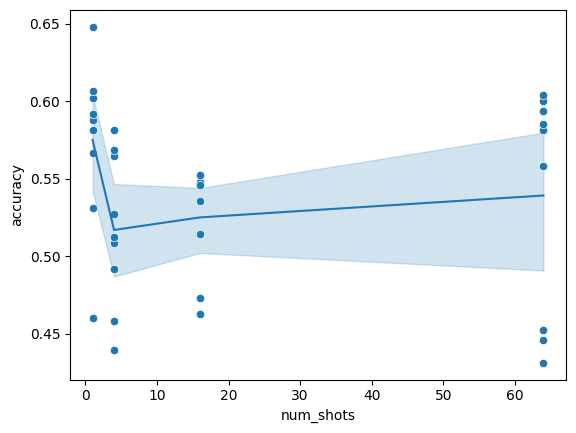

In [76]:
sns.lineplot(data=results, x="num_shots", y="accuracy")
sns.scatterplot(data=results, x="num_shots", y="accuracy")

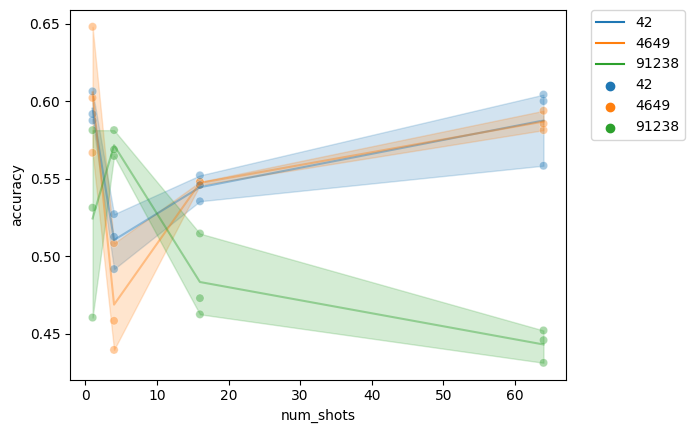

In [78]:
results["split_seed"] = results["split_seed"].astype(str)
sns.lineplot(data=results, x="num_shots", y="accuracy", hue="split_seed", alpha=0.4)
sns.scatterplot(data=results, x="num_shots", y="accuracy", hue="split_seed", alpha=0.4)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

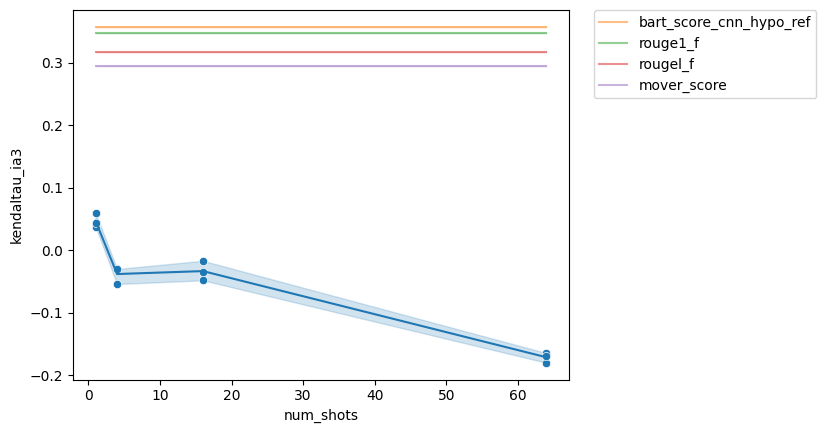

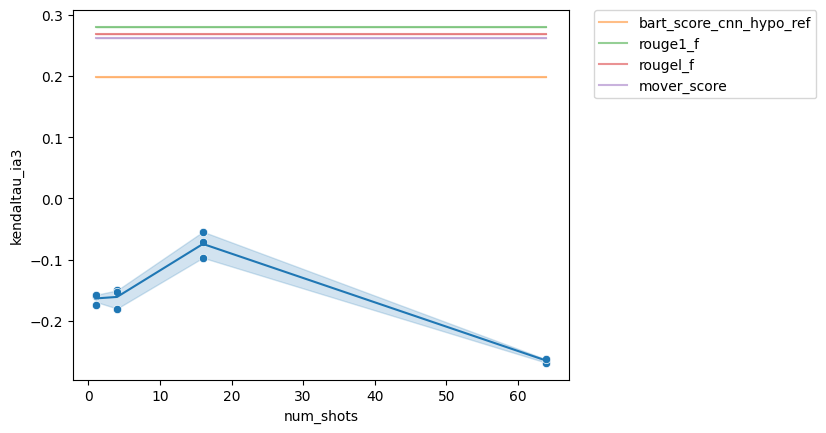

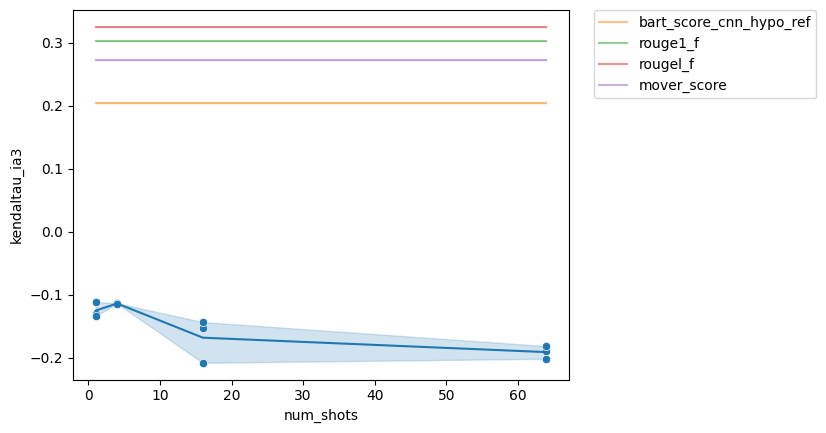

In [84]:
# 9 points each
for seed in (42, 4649, 91238):
    data_seed = results[results["split_seed"]==str(seed)]
    sns.lineplot(data=data_seed, x="num_shots", y=f"kendaltau_ia3")
    sns.scatterplot(data=data_seed, x="num_shots", y=f"kendaltau_ia3")

    for metric in metrics_corr[1::2]:
        sns.lineplot(data=data_seed, x="num_shots", y=metric, label=metric[10:], alpha=0.5)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

In [68]:
results.groupby("split_seed").mean()[["kendaltau_ia3"] + metrics_corr]

,kendaltau_ia3,kendaltau_bart_score_hypo_ref,kendaltau_bart_score_cnn_hypo_ref,kendaltau_bart_score_para_hypo_ref,kendaltau_rouge1_f,kendaltau_rouge2_f,kendaltau_rougel_f,kendaltau_prism_hypo_ref,kendaltau_mover_score
split_seed,,,,,,,,,
42,-0.049185,0.351378,0.357377,0.363612,0.347807,0.314175,0.317160,0.312712,0.294420
4649,-0.165757,0.225807,0.198154,0.274829,0.280162,0.257569,0.268782,0.265182,0.261392
91238,-0.149323,0.269734,0.203403,0.280526,0.302669,0.372768,0.325000,0.286375,0.272016


In [85]:
sns.boxplot(data=results, x="num_shots", y=f"kendaltau_ai3")

ValueError: Could not interpret input 'kendaltau_ai3'

In [ ]:
file = all_files[0]

for file in all_files:
    df = pd.read_csv(file)
    scores = np.where(
            (df['label']==df['pred']), 
            # if true
            df["log.label_score"], 
            # else
            np.where(df["label"] == "Yes" , df["log.label_score"], df["log.pred_score"]))
    
    scores = np.exp(-scores)
    sns.histplot(x=scores, hue=df['label'].values)
    plt.title(file)
    plt.show()

In [44]:
df["label"]

0       No
1      Yes
2      Yes
3      Yes
4       No
      ... 
475     No
476    Yes
477     No
478    Yes
479     No
Name: label, Length: 480, dtype: object